In [1]:
import pandas as pd
import numpy as np
from stock_data import StockData

In [2]:
stock = StockData('sp_400_midcap.csv', '662166cb8e3d13.57537943')
df = stock.fetch_all_stocks(sector='Materials', period = 'd', start = '2000-01-01', end = '2024-8-30')

In [7]:
def log_ret(s:pd.Series):
    return np.log(s / s.shift(1))

df['log_ret'] = df.groupby('ticker', group_keys=False)['adjusted_close'].apply(log_ret)

In [17]:
df['w'] = df.groupby('date', group_keys=False)['adjusted_close'].transform(lambda x : 1 / len(x))

In [22]:
equal_w_index = df.groupby('date').apply(lambda x: x['log_ret']@x['w'])

<Axes: xlabel='date'>

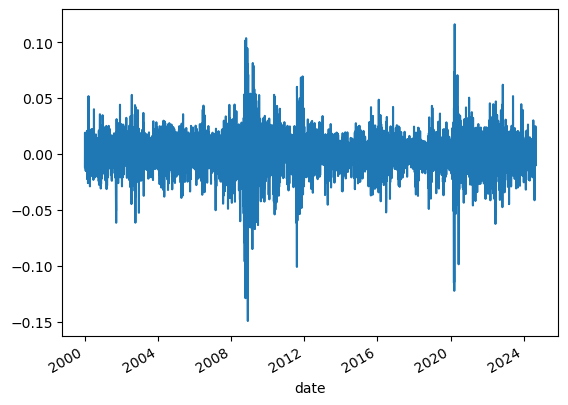

In [23]:
equal_w_index.plot()

In [24]:
equal_w_index

date
2000-01-03         NaN
2000-01-04   -0.011152
2000-01-05    0.014503
2000-01-06    0.019151
2000-01-07    0.001463
                ...   
2024-08-26    0.002536
2024-08-27   -0.007176
2024-08-28   -0.010168
2024-08-29    0.009288
2024-08-30    0.005963
Length: 6205, dtype: float64